In [5]:
from enum import IntEnum
from time import time
# from tqdm._tqdm_notebook import tqdm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import KetSugar as ks
# import MaxLik as ml

#note: np.savez(f'saved_samples_q{qubits}.npz', naive=naive_rec, calib=tru_rec, reference=kets)

In [6]:
class Columns(IntEnum):
    qubits = 0
    pur_nai_mu = 1
    pur_nai_q1 = 2
    pur_nai_q2 = 3
    pur_cal_mu = 4
    pur_cal_q1 = 5
    pur_cal_q2 = 6
    fid_nai_mu = 7
    fid_nai_q1 = 8
    fid_nai_q2 = 9
    fid_cal_mu = 10
    fid_cal_q1 = 11
    fid_cal_q2 = 12

QUBITS = [1,2,3,4,5]
table = np.zeros((len(QUBITS), len(Columns)))
Quant1 = 0.158
Quant2 = 1 - Quant1

for i, qubits in enumerate(QUBITS):
    rhos_naive = np.load(f'saved_samples_q{qubits}.npz')['naive']
    rhos_calib = np.load(f'saved_samples_q{qubits}.npz')['calib']
    ket_reference = np.load(f'saved_samples_q{qubits}.npz')['reference']
    dim = ket_reference.shape[1]
    rho_reference = np.array([ks.ketbra(k,k) for k in ket_reference.reshape((-1,dim,1))])
    
    purities_naive = np.einsum('kij,kji->k', rhos_naive, rhos_naive).real
    purities_calib = np.einsum('kij,kji->k', rhos_calib, rhos_calib).real

    table[i, Columns.qubits] = qubits
    table[i, Columns.pur_nai_mu] = np.median(purities_naive) #purities_nai_mu 
    table[i, Columns.pur_nai_q1] = np.quantile(purities_naive, Quant1) #purities_nai_std
    table[i, Columns.pur_nai_q2] = np.quantile(purities_naive, Quant2) #purities_nai_std
    
    table[i, Columns.pur_cal_mu] = np.median(purities_calib) #purities_cal_mu
    table[i, Columns.pur_cal_q1] = np.quantile(purities_calib, Quant1) #purities_cal_std
    table[i, Columns.pur_cal_q2] = np.quantile(purities_calib, Quant2) #purities_cal_std
    
    fid_nai = np.einsum('kij,kji->k', rho_reference, rhos_naive).real
    fid_cal = np.einsum('kij,kji->k', rho_reference, rhos_calib).real
    table[i, Columns.fid_cal_mu] = np.median(fid_cal) #fids_cal_mu
    table[i, Columns.fid_cal_q1] = np.quantile(fid_cal, Quant1) #fids_cal_std
    table[i, Columns.fid_cal_q2] = np.quantile(fid_cal, Quant2) #fids_cal_std
    
    table[i, Columns.fid_nai_mu] = np.median(fid_nai) #fids_cal_mu
    table[i, Columns.fid_nai_q1] = np.quantile(fid_nai, Quant1) #fids_cal_std
    table[i, Columns.fid_nai_q2] = np.quantile(fid_nai, Quant2) #fids_cal_std



In [57]:
rhos_nai = np.load('saved_samples_q1.npz')['naive']
ket_reference = np.load('saved_samples_q1.npz')['reference'].reshape((-1,2,1))
purities_naive = np.einsum('ijk,ikj->i', rhos_nai, rhos_nai).real #'kij,kji->k'
argmin = np.argmin(purities_naive)
rho_worst = rhos_nai[argmin]
P_worst = purities_naive[argmin]
rho_reference = ks.ketbra(ket_reference[argmin],ket_reference[argmin])
F_worst = ks.Fidelity(rho_reference, rho_worst)
print(P_worst, F_worst)

0.8629137338370538 0.925638073302594


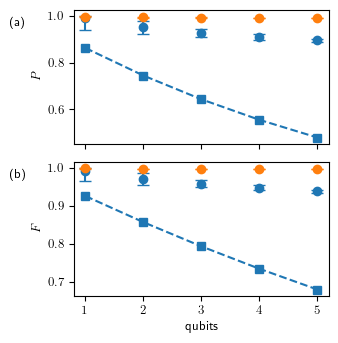

In [62]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = 9
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['figure.figsize'] = (3.5, 3.5)

fig, ax = plt.subplots(2,1, sharex=True)
#ax[0].plot(table[:, Columns.qubits], P_worst**table[:, Columns.qubits], "--s", c='0.5')
ax[0].plot(table[:, Columns.qubits], P_worst**table[:, Columns.qubits], "--s", c='C0')
ax[1].plot(table[:, Columns.qubits], F_worst**table[:, Columns.qubits], "--s", c='C0')

ax[0].errorbar(
    x = table[:, Columns.qubits],
    y = table[:, Columns.pur_nai_mu], 
    yerr = (table[:, Columns.pur_nai_mu] - table[:, Columns.pur_nai_q1], table[:, Columns.pur_nai_q2] - table[:, Columns.pur_nai_mu]), 
    ls='', 
    marker="o", 
    capsize=4
)
ax[0].errorbar(
    x = table[:, Columns.qubits],
    y = table[:, Columns.pur_cal_mu], 
    yerr = (table[:, Columns.pur_cal_mu] - table[:, Columns.pur_cal_q1], table[:, Columns.pur_cal_q2] - table[:, Columns.pur_cal_mu]), 
    ls='', 
    marker="o", 
    capsize=4
)
ax[1].errorbar(
    x = table[:, Columns.qubits],
    y = table[:, Columns.fid_nai_mu], 
    yerr = (table[:, Columns.fid_nai_mu] - table[:, Columns.fid_nai_q1], table[:, Columns.fid_nai_q2] - table[:, Columns.fid_nai_mu]), 
    ls='', 
    marker="o", 
    capsize=4
)
ax[1].errorbar(
    x = table[:, Columns.qubits],
    y = table[:, Columns.fid_cal_mu], 
    yerr = (table[:, Columns.fid_cal_mu] - table[:, Columns.fid_cal_q1], table[:, Columns.fid_cal_q2] - table[:, Columns.fid_cal_mu]), 
    ls='', 
    marker="o", 
    capsize=4
)

ax[-1].set_xlabel('qubits')
ax[0].set_ylabel('$P$')
ax[1].set_ylabel('$F$')
ax[1].set_xticks(QUBITS)
ax[0].text(-0.25, 0.95, '(a)', transform=ax[0].transAxes,va='top', ha='left')
ax[1].text(-0.25, 0.95, '(b)', transform=ax[1].transAxes, va='top', ha='left')
plt.tight_layout()
plt.show()